## **Notebook Setup: Imports, GPU/CPU Check, and Optimizer Configuration**

This notebook cell performs the initial environment setup, including importing required libraries and checking your current hardware environment:

- **TensorFlow** and **Keras** are imported for building and training deep learning models.
- We define a custom function `get_optimizer_for_platform()` to detect if your system is running on Apple Silicon (M1/M2). TensorFlow has a known issue causing slowdowns on these chips with the default optimizer implementation, so this function automatically selects the legacy Adam optimizer when necessary.
- Finally, the cell prints out TensorFlow version information and checks whether a GPU is available. If a GPU is found, it will be used automatically by TensorFlow, greatly speeding up model training. If not, it will default to using your CPU.

---

**Things to check when running this cell**:

- Confirm TensorFlow is properly installed and check the printed version (2.13.0 is used for this exercise)
- Verify whether your notebook is correctly detecting the presence (or absence) of a GPU. (Absence of a GPU is not a problem, a CPU is also enough to complete this exercise)

In [1]:
!pip install visualkeras

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import visualkeras
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image
import numpy as np
import os
import platform
import time
import random
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="visualkeras")

seed = 142

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

#tf.config.threading.set_inter_op_parallelism_threads(1)
#tf.config.threading.set_intra_op_parallelism_threads(1)

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

def get_optimizer_for_platform(learning_rate=1e-3):
    """
    Returns legacy Adam if running on Apple Silicon (M1/M2)
    to avoid known slowdowns in TF 2.11+,
    otherwise returns the standard Adam optimizer.
    """
    # Check if platform is Mac (Darwin) and Apple Silicon (arm64)
    is_apple_silicon = (platform.system() == "Darwin") and ("arm64" in platform.platform())
    
    if is_apple_silicon:
        print("Detected Apple Silicon. Using legacy Adam optimizer.")
        return tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    else:
        print("Using standard Adam optimizer.")
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)

print("TensorFlow version:", tf.__version__)

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected. The following GPU(s) will be used:")
    for idx, gpu in enumerate(gpus):
        print(f"  GPU {idx}: {gpu}")
else:
    print("No GPU detected. Using CPU instead.")


2025-03-31 13:47:24.516396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.13.1
No GPU detected. Using CPU instead.


###  **Task 1: Model Training**

In this step, we:

- Load the **CIFAR-10** dataset, which consists of **60,000** 32x32 color images across **10 classes**.
- Normalize the image pixel values from the original range `[0, 255]` to `[0, 1]` to help the model learn more efficiently.
- Convert labels from integers to **one-hot encoded vectors**, making them suitable for classification with a categorical cross-entropy loss.
- Split the original training data into two subsets:
  - **Training set**: 90% of the original training data.
  - **Validation set**: 10% of the original training data.  
  This allows us to monitor performance and prevent overfitting by checking accuracy on data the model hasn't trained on.

**Key Points:**
- CIFAR-10 has **60,000 color images (32x32 pixels)** in 10 classes, split into:
  - 50,000 images for training.
  - 10,000 images reserved for testing.
- Classes in CIFAR-10 include: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

---

### **Discussion Points:**
- Why do we use one-hot encoding for labels?
- What is the purpose of creating a validation set?

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Scale images to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Create a validation set from training data (e.g., 10% validation split)
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, shuffle=True
)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

170498071/170498071 [==============================] - 10s 0us/step
Training data shape: (45000, 32, 32, 3)
Validation data shape: (5000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


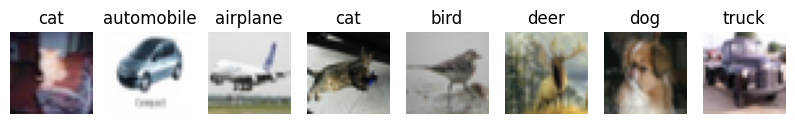

In [4]:
# -----------------------------------------
# Display some images and their classes
# -----------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Show the first num_images images in x_train
num_images = 8
plt.figure(figsize=(10,2))

for i in range(num_images):
    ax = plt.subplot(1, num_images, i+1)
    
    label_index = np.argmax(y_train[i])
    
    # Display the image
    plt.imshow(x_train[i])
    plt.title(class_names[label_index])
    plt.axis("off")

plt.show()


### **Define the CNN Model for CIFAR-10 Classification**

This notebook cell defines a Convolutional Neural Network (CNN) architecture tailored for classifying the CIFAR-10 dataset. The architecture consists of:

- **Three convolutional blocks**, each designed to progressively capture more complex features from the input images:
  - **Block 1:** Extracts basic features using two `Conv2D` layers with 32 filters, followed by batch normalization and dropout to reduce overfitting.
  - **Block 2:** Uses two `Conv2D` layers with 64 filters for deeper feature extraction, again applying batch normalization, pooling, and dropout.
  - **Block 3:** Uses two `Conv2D` layers with 128 filters, again with batch normalization.

- **Global Average Pooling** (`GlobalAveragePooling2D`): Reduces feature maps to a vector, capturing high-level information across the entire image.

- **Fully-connected (dense) layers**:
  - A hidden layer with **256 units** and a ReLU activation to refine extracted features.
  - A final layer with **10 units** and **softmax activation**, producing a probability distribution across the 10 CIFAR-10 classes.

- **Dropout layers**: Regularization technique applied throughout to mitigate **overfitting** by randomly deactivating neurons during training.

**Questions to Consider:**
- How many total parameters does this model have?
- How would changing the number of filters in convolutional layers affect model complexity and accuracy?

In [5]:
def build_cifar10_model():
    inputs = tf.keras.Input(shape=(32, 32, 3))

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Global Average Pooling + final dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [6]:
model = build_cifar10_model()
model.summary()
small_model = model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0     

### **Compile the Model**

In this cell, we compile the model, specifying how it will learn from the data:

- **Optimizer (`Adam`)**: An efficient and popular optimizer that adapts learning rates for each parameter, often providing fast and stable convergence.
- **Loss function (`categorical_crossentropy`)**: Used for multi-class classification tasks when labels are one-hot encoded.
- **Metrics (`accuracy`)**: Tracks the fraction of correctly classified examples during training and validation.

**Special note for Apple Silicon Macs**:  
The provided code automatically selects between TensorFlow’s standard `Adam` optimizer and the legacy version (`tf.keras.optimizers.legacy.Adam`) based on your hardware.

In [7]:
model.compile(
    optimizer=get_optimizer_for_platform(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Using standard Adam optimizer.


### **Model Checkpointing**

This cell sets up a **checkpoint callback** for the training process. The callback automatically saves the **best-performing model weights** based on the **highest validation accuracy** (`val_accuracy`). By using this callback:

- Only the weights corresponding to the best validation performance are saved (`save_best_only=True`).
- The weights are saved in a file named `"best_model_checkpoint.h5"`.

Later, you can easily restore these weights to perform inference or further training without losing progress.

**Points to Consider:**
- Why is checkpointing valuable during model training?

In [8]:
checkpoint_path = "best_model_checkpoint.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


### **Model Training**

In this cell, we start the training process for the CNN model using the training set:

- **Epochs** (`train_epochs = 10`): The entire training dataset will be processed **10 times**, allowing the model to improve gradually.
- **Batch Size** (`train_batch_size = 64`): The number of images used in each training step. A batch size of **64** strikes a balance between memory usage and convergence stability.
- **Validation Data**: During training, the model's performance is evaluated on the validation set (`x_val`, `y_val`) at the end of each epoch. This helps prevent overfitting and provides an estimate of generalization performance.

**After training**, the checkpoint callback saves only the weights from the epoch with the highest validation accuracy.


In [9]:
train_epochs     = 5
train_batch_size = 64

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=train_epochs,
    batch_size=train_batch_size,
    callbacks=[checkpoint_callback]
)


Epoch 1/5
703/704 [============================>.] - ETA: 0s - loss: 1.5823 - accuracy: 0.4164
Epoch 1: val_accuracy improved from -inf to 0.53400, saving model to best_model_checkpoint.h5
704/704 [==============================] - 163s 228ms/step - loss: 1.5823 - accuracy: 0.4164 - val_loss: 1.3498 - val_accuracy: 0.5340
Epoch 2/5
704/704 [==============================] - ETA: 0s - loss: 1.2274 - accuracy: 0.5587
Epoch 2: val_accuracy improved from 0.53400 to 0.58440, saving model to best_model_checkpoint.h5
704/704 [==============================] - 149s 212ms/step - loss: 1.2274 - accuracy: 0.5587 - val_loss: 1.1464 - val_accuracy: 0.5844
Epoch 3/5
703/704 [============================>.] - ETA: 0s - loss: 1.0958 - accuracy: 0.6106
Epoch 3: val_accuracy improved from 0.58440 to 0.62700, saving model to best_model_checkpoint.h5
704/704 [==============================] - 149s 211ms/step - loss: 1.0957 - accuracy: 0.6106 - val_loss: 1.0369 - val_accuracy: 0.6270
Epoch 4/5
704/704 [===

### **Evaluate the Trained Model Using the Best Checkpoint**

In this step, we load the **best model weights** saved during training—those corresponding to the highest validation accuracy—and evaluate the model on the **test dataset**. This allows us to measure how well the model generalizes to unseen data, providing a reliable estimate of real-world performance.

**Key Points:**
- The best checkpoint was selected based on **highest validation accuracy**.
- The evaluation result (test accuracy) gives us the most realistic expectation of the model's actual predictive performance.

**Discussion Questions:**
- Why do we use the test set rather than the validation set for the final evaluation?
- What does a large gap between validation and test accuracies indicate about the model?

In [10]:

model.load_weights(checkpoint_path)
loss, small_model_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Best checkpoint TF model test accuracy: {small_model_acc:.4f}")
print(f"Best checkpoint TF model loss: {loss:.4f}")


Best checkpoint TF model test accuracy: 0.6484
Best checkpoint TF model loss: 1.0242


### **Task 2: Post-Training Integer Quantization of the Model**

In this cell, the previously trained Keras model (`model`) is converted into a **fully quantized TensorFlow Lite model** (`INT8`). This quantization process significantly reduces the model's size and memory footprint, making it suitable for deployment on resource-constrained devices (e.g., microcontrollers or mobile phones).

**How this works:**
- We use a **representative dataset** (100 images from the training set) for calibration. This step helps TensorFlow Lite determine how to optimally map floating-point values to INT8 representation.
- The model parameters and intermediate activations are converted from FP32 (32-bit floats) to INT8 (8-bit integers), greatly reducing the size and improving inference speed at the potential cost of minor accuracy loss.

**Output:**
- The quantized model is saved to the file: `"quantized_model.tflite"`.

**Questions for discussion:**
- How much size reduction do you expect from quantization?
- What impact might quantization have on model accuracy?

In [11]:
# Post-Training Quantization (Full Integer)

def representative_data_gen():
    # Provide a small subset of training data for calibration
    for i in range(100):
        yield [x_train[i:i+1]]

# Convert Keras model to TFLite with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

# Save the quantized model
quantized_model_path = "quantized_model.tflite"
with open(quantized_model_path, "wb") as f:
    f.write(tflite_quant_model)

print("Quantized TFLite model saved to:", quantized_model_path)


INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmpnfdhw82y/assets


INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmpnfdhw82y/assets
/Users/eliowanner/anaconda3/envs/mfcc_test/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-31 14:00:57.441052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-31 14:00:57.441073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-31 14:00:57.441456: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmpnfdhw82y
2025-03-31 14:00:57.446538: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-31 14:00:57.446565: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/r0/xn4tv_vn5nv3y

Quantized TFLite model saved to: quantized_model.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


## **Evaluate the Quantized TFLite Model on CIFAR-10 Test Data**

In this cell, we **evaluate the fully integer-quantized (INT8) TFLite model** using the CIFAR-10 test set. The process involves:

- Loading the quantized model (`.tflite` file).
- Adjusting input images from floating-point values `[0,1]` to the INT8 representation required by the quantized model, using the model's input scale and zero-point.
- Running inference using TensorFlow Lite's interpreter to predict class labels for each image.
- Calculating accuracy by comparing the predicted labels with the ground-truth labels.

This evaluation allows us to compare the quantized model's performance directly with the original (non-quantized) model, providing insights into the trade-off between model size and accuracy.

**Questions:**

- How did accuracy, if any, change after quantization?
- What benefits do quantized models have in practical deployment scenarios, such as embedded devices?


In [12]:
# Evaluate Quantized TFLite Model

def evaluate_tflite_model(tflite_model_path, x_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # We'll assume per-tensor quantization
    input_scale, input_zero_point = input_details[0]['quantization']

    correct = 0
    total = x_test.shape[0]

    for i in range(total):
        # Convert float [0,1] to int8 using scale, zero_point
        float_img = x_test[i:i+1]
        int8_img = np.round(float_img / input_scale + input_zero_point).astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], int8_img)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])
        pred_label = np.argmax(output_data[0])
        true_label = np.argmax(y_test[i])
        if pred_label == true_label:
            correct += 1

    accuracy = correct / total
    return accuracy

small_quantized_acc = evaluate_tflite_model(quantized_model_path, x_test, y_test)
print(f"Quantized TFLite model test accuracy: {small_quantized_acc:.4f}")


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Quantized TFLite model test accuracy: 0.6507


### **Confusion Matrix Interpretation**

This plot shows a **confusion matrix** visualized using a heatmap, indicating the performance of the classification model on the CIFAR-10 test dataset:

- **Diagonal cells**: Represent correctly classified images, with darker shades indicating a higher number of correct predictions.
- **Off-diagonal cells**: Represent misclassifications; lighter colors indicate fewer errors.

The color intensity provides a visual guide to quickly identify areas where the model performs well (darker diagonal) and where it struggles (lighter or darker off-diagonal cells).

**Discussion Questions:**

- Which classes does the model classify most accurately?
- Are there specific classes that the model tends to confuse?
- How can you use this confusion matrix to improve your model?

313/313 [==============================] - 8s 26ms/step
Confusion Matrix Small Model:
[[811   5  43   1  31   1  17   1  83   7]
 [ 94 661   5   0   5   0  31   1 119  84]
 [117   0 437   7 209  43 160  14   9   4]
 [ 30   2  51 216 219 108 299  22  40  13]
 [ 23   0  33   8 789   1 118  18   9   1]
 [ 15   0  68  79 223 411 136  43  20   5]
 [  6   0  30   8  65   3 882   1   5   0]
 [ 28   0  46   2 242  23  33 614   4   8]
 [ 80   4   6   1  15   0   8   1 880   5]
 [ 76  22   8   1  18   0  30   1  61 783]]


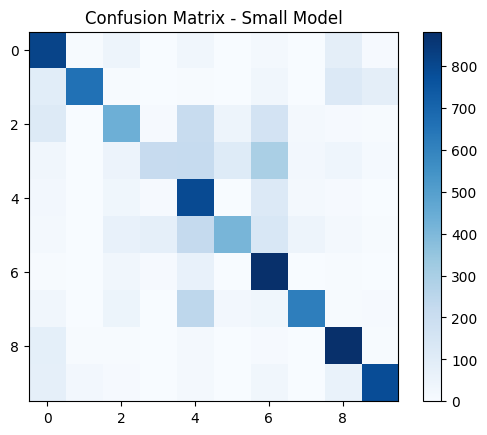

In [13]:
# Confusion Matrix for the original TF model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def show_confusion_matrix(input_model, name):
    y_pred = input_model.predict(x_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    
    print(f"Confusion Matrix {name}:")
    print(cm)
    
    # (Optional) Visualize the confusion matrix
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.colorbar()
    plt.show()

show_confusion_matrix(model, "Small Model")


### **Task 3: Teacher Model Interpretation**

This cell loads the pre-trained **teacher model** from the file `teacher.h5`. The teacher model is usually a larger and more complex model trained earlier, often achieving higher accuracy.

Here:

- **Loading** the model from the file.
- Printing the model's **summary**, which provides a detailed overview of its layers, output shapes, and total number of parameters.

The teacher model will be used later as a source of knowledge for training smaller, efficient student models.

**Questions to Consider:**

- What role does the teacher model play in knowledge distillation?
- Why is the teacher model typically larger and more accurate than the student model?
- How many parameters does the teacher model have compared to the student model?

In [14]:
# Load the teacher model from 'teacher.h5'
teacher_model = tf.keras.models.load_model("teacher.h5")

# Summarize the teacher model
teacher_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                        


### **Evaluate the Teacher Model on the Test Set**

In this cell, we evaluate the **teacher model**'s performance on the **CIFAR-10 test dataset** to determine its accuracy. The teacher model typically serves as the performance baseline due to its higher complexity and accuracy.

The evaluation provides:

- **Loss**: A measure of how well the model predictions match the actual labels.
- **Accuracy**: The percentage of correctly classified test images.

**Discussion Questions:**

- How does the teacher model’s accuracy compare with the student model's accuracy?
- Why might the teacher model be more accurate?
- Is the teacher model accuracy significantly higher, justifying the increased model complexity?

In [15]:
# Evaluate the teacher model on the same test set
teacher_loss, teacher_acc = teacher_model.evaluate(x_test, y_test, verbose=0)
print(f"Teacher model test accuracy: {teacher_acc:.4f}")
print(f"Teacher model test loss: {teacher_loss:.4f}")

Teacher model test accuracy: 0.8897
Teacher model test loss: 0.3531


313/313 [==============================] - 23s 73ms/step
Confusion Matrix Teacher Model:
[[917   8  11   2   4   0   5   2  26  25]
 [  2 966   0   0   0   0   1   0   2  29]
 [ 31   0 872   3  24  10  36  14   5   5]
 [ 13   4  47 687  45  74  74  27  11  18]
 [  3   1  27  10 897   2  40  20   0   0]
 [  4   6  42  55  24 783  41  34   2   9]
 [  5   1  15   8   6   0 961   1   2   1]
 [  7   0  10   7  18   1   6 946   1   4]
 [ 35  11   5   0   0   0   3   0 917  29]
 [  5  35   0   1   1   1   1   1   4 951]]


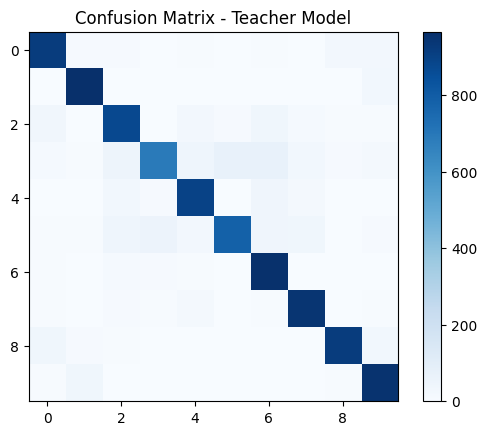

In [16]:
show_confusion_matrix(teacher_model, "Teacher Model")

##  **Quantize and Evaluate the Teacher Model (INT8)**

In this cell, we perform **post-training integer quantization (INT8)** on the teacher model, following a similar approach as previously used. The purpose of quantizing the teacher model is to:

- Significantly reduce model size and memory usage.
- Improve inference efficiency, enabling deployment on devices with limited resources.

**Steps taken:**
- Convert the teacher model from floating-point (FP32) to integer (INT8) precision.
- Save the quantized TFLite model as `"quantized_teacher_model.tflite"`.
- Evaluate the quantized model's accuracy on the CIFAR-10 test set to understand how quantization affects performance.

**Points for Discussion:**
- How does the quantized teacher model's accuracy compare with its FP32 version?
- Why is it important to quantify accuracy loss due to quantization?

In [17]:
# ======================
# Quantize the Teacher Model & Compare Models
# ======================

converter = tf.lite.TFLiteConverter.from_keras_model(teacher_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_teacher_model = converter.convert()

quantized_teacher_model_path = "quantized_teacher_model.tflite"
with open(quantized_teacher_model_path, "wb") as f:
    f.write(tflite_quant_teacher_model)

print("Quantized Teacher TFLite model saved to:", quantized_teacher_model_path)

teacher_quant_acc = evaluate_tflite_model(quantized_teacher_model_path, x_test, y_test)
print(f"Quantized (INT8) Teacher model test accuracy: {teacher_quant_acc:.4f}")


INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp8y4efhmq/assets


INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp8y4efhmq/assets
/Users/eliowanner/anaconda3/envs/mfcc_test/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-31 14:02:13.460693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-31 14:02:13.460713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-31 14:02:13.460927: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp8y4efhmq
2025-03-31 14:02:13.468287: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-31 14:02:13.468315: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/r0/xn4tv_vn5nv3y

Quantized Teacher TFLite model saved to: quantized_teacher_model.tflite
Quantized (INT8) Teacher model test accuracy: 0.8884


## **Comparing Model Performance: Teacher vs Small Model**

This cell presents a detailed **side-by-side comparison** of both the Teacher and Small models, highlighting:

- **Accuracy**:
  - Comparison of accuracy between original floating-point (FP32) and quantized integer (INT8) models.
  - Calculation of accuracy differences helps illustrate the impact quantization has on each model.

- **Model Complexity (Parameters)**:
  - Number of parameters for both the Teacher and Small models.
  - Difference in parameters indicates how much smaller or simpler the Small model is compared to the Teacher.

This comparison is crucial for understanding the trade-offs between model size, computational requirements, and accuracy when choosing a suitable model for deployment.

**Discussion Points:**
- How significant is the accuracy loss from FP32 to INT8 quantization for each model?
- In practical scenarios, under what conditions might you prefer the Small model over the Teacher model?

In [18]:
print("\n===== Comparison =====")
# Teacher FP32
print(f"Teacher model accuracy (FP32):           {teacher_acc:.4f}")
# Teacher INT8
print(f"Teacher model accuracy (INT8):           {teacher_quant_acc:.4f}")
print(f"Accuracy diff (Teacher FP32 - Teacher INT8): {teacher_acc - teacher_quant_acc:.4f}")

# Small FP32
print(f"\nSmall model accuracy (FP32):             {small_model_acc:.4f}")
# Small INT8
print(f"Small model accuracy (INT8):             {small_quantized_acc:.4f}")
print(f"Accuracy diff (Small FP32 - Small INT8): {small_model_acc - small_quantized_acc:.4f}")

# Number of parameters
small_model = model
teacher_params = teacher_model.count_params()
small_params   = model.count_params()

print(f"\nTeacher model parameters:   {teacher_params}")
print(f"Small model parameters:     {small_params}")
print(f"Parameter difference:       {teacher_params - small_params}")


===== Comparison =====
Teacher model accuracy (FP32):           0.8897
Teacher model accuracy (INT8):           0.8884
Accuracy diff (Teacher FP32 - Teacher INT8): 0.0013

Small model accuracy (FP32):             0.6484
Small model accuracy (INT8):             0.6507
Accuracy diff (Small FP32 - Small INT8): -0.0023

Teacher model parameters:   3253834
Small model parameters:     324394
Parameter difference:       2929440


## **Calculate and Compare Memory Footprint of Models (FP32 vs INT8)**

In this cell, we calculate the approximate **memory requirements** of both the Teacher and Small models in two data formats:

- **FP32 (float32)**: Each parameter occupies **4 bytes**.
- **INT8 (integer quantized)**: Each parameter occupies **1 byte**.

By comparing these memory footprints, we clearly see the benefit of quantizing models from FP32 to INT8, significantly reducing storage and memory usage.

**Key Insights:**
- Quantized models typically use **4x less memory** than their FP32 counterparts.
- This reduction can lead to faster inference speeds and lower power consumption, particularly on devices with limited resources.

**Questions to Explore:**
- How critical is memory footprint for your deployment scenario? **Please check your microcontroller's datasheet** and try to understand if any of these models can fit into your microcontroller memory.

In [19]:
# =============================
# Calculate Memory Footprint for FP32 & INT8
# =============================

BYTES_PER_FP32 = 4
BYTES_PER_INT8 = 1
BYTES_PER_KB   = 1024
BYTES_PER_MB   = 1024 * 1024

def calc_memory_usage(num_params, bytes_per_param):
    total_bytes = num_params * bytes_per_param
    kb = total_bytes / BYTES_PER_KB
    mb = total_bytes / BYTES_PER_MB
    return total_bytes, kb, mb

# Teacher model: FP32
teacher_fp32_bytes, teacher_fp32_kb, teacher_fp32_mb = calc_memory_usage(teacher_params, BYTES_PER_FP32)

# Teacher model: INT8
teacher_int8_bytes, teacher_int8_kb, teacher_int8_mb = calc_memory_usage(teacher_params, BYTES_PER_INT8)

# Small model: FP32
small_fp32_bytes, small_fp32_kb, small_fp32_mb = calc_memory_usage(small_params, BYTES_PER_FP32)

# Small model: INT8
small_int8_bytes, small_int8_kb, small_int8_mb = calc_memory_usage(small_params, BYTES_PER_INT8)

print("===== Memory Footprint (Approximate) =====")
print("\nTeacher Model:")
print(f"  FP32: {teacher_fp32_bytes} bytes | {teacher_fp32_kb:.2f} KB | {teacher_fp32_mb:.2f} MB")
print(f"  INT8: {teacher_int8_bytes} bytes | {teacher_int8_kb:.2f} KB | {teacher_int8_mb:.2f} MB")

print("\nSmall Model:")
print(f"  FP32: {small_fp32_bytes} bytes | {small_fp32_kb:.2f} KB | {small_fp32_mb:.2f} MB")
print(f"  INT8: {small_int8_bytes} bytes | {small_int8_kb:.2f} KB | {small_int8_mb:.2f} MB")


===== Memory Footprint (Approximate) =====

Teacher Model:
  FP32: 13015336 bytes | 12710.29 KB | 12.41 MB
  INT8: 3253834 bytes | 3177.57 KB | 3.10 MB

Small Model:
  FP32: 1297576 bytes | 1267.16 KB | 1.24 MB
  INT8: 324394 bytes | 316.79 KB | 0.31 MB


Teacher Model Architecture:



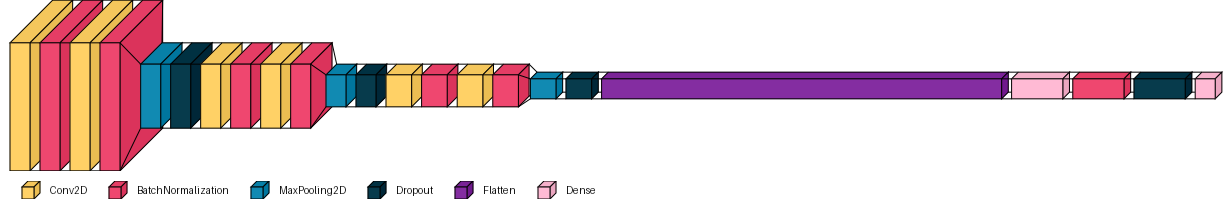





Small Model Architecture:



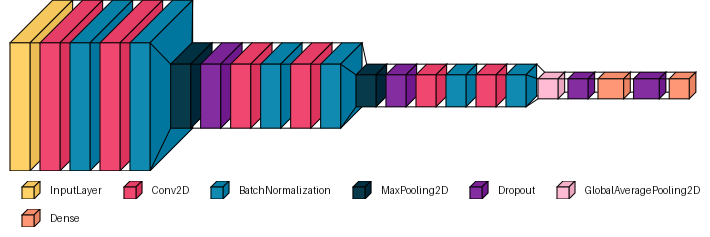

In [20]:
# Function to display the visualized model
def show_model_visualization(model, title):
    img = visualkeras.layered_view(model, legend=True)  # Generate visualization
    img_path = f"{title}.png"
    img.save(img_path)  # Save as an image
    display.display(Image.open(img_path))  # Display in Jupyter Notebook

# Visualizing models
print("Teacher Model Architecture:\r\n")
show_model_visualization(teacher_model, "teacher_model")

print("\r\n\n")

print("\nSmall Model Architecture:\r\n")
show_model_visualization(small_model, "small_model")

## **Task 4: Knowledge Distillation**

This cell introduces a custom class, `Distiller`, that implements the **knowledge distillation** training approach using Keras. Knowledge distillation aims to transfer knowledge from a large, accurate **teacher model** to a smaller, more efficient **student model**.

### **How the Distiller Class Works:**

- **Initialization:**
  - Accepts two models:
    - A pre-trained **teacher model** (larger, high-performance).
    - A smaller **student model** (simpler, faster).
    
- **Compilation Parameters:**
  - **Optimizer**: Used to update the student model's weights.
  - **Metrics**: Metrics for evaluating the student model (e.g., accuracy).
  - **Student loss function** (`student_loss_fn`): Measures how well the student predictions match the true labels (hard labels).
  - **Distillation loss function** (`distillation_loss_fn`): Measures the difference between teacher and student predictions using softened probabilities (soft labels).
  - **Alpha (`α`)**: Balances the contribution of the student loss and distillation loss:
    - `loss = α * student_loss + (1 - α) * distillation_loss`
  - **Temperature (`T`)**: Used to soften probability distributions, making it easier for the student model to learn from the teacher's predictions:
    - Higher temperatures produce softer distributions, emphasizing relationships among classes.

- **Custom `train_step`:**
  - Performs a forward pass with both teacher (no gradient) and student (gradient computed).
  - Calculates two losses:
    - **Student loss**: Measures the student's performance against true labels.
    - **Distillation loss**: Encourages the student model to mimic the softened predictions of the teacher model.
  - Combines losses using the factor `α`.
  - Updates the student model parameters by backpropagating the combined loss.
  - Updates and returns training metrics and individual loss values.

- **Custom `test_step`:**
  - Evaluates student model performance during validation or testing.
  - Updates and returns evaluation metrics, including the student loss.

### **Important Notes:**
- Because the teacher model outputs probabilities (softmax), the implementation re-applies softmax after scaling by temperature. Although not mathematically ideal (logits would be preferred), this practical approach typically performs well.
- Multiplying the distillation loss by `T²` (temperature squared) is a standard best practice from the original knowledge distillation paper by Hinton et al.

---

### **Questions for Further Exploration:**
- What happens to the student model’s accuracy when changing the temperature parameter? (Check the mathematical expression)
- How sensitive is the knowledge distillation process to the choice of alpha (α)? (Check the mathematical expression)
- Could removing the teacher's softmax layer (using logits directly) improve distillation performance?

In [21]:
# Define Distiller for Knowledge Distillation

class Distiller(tf.keras.Model):
    """
    Custom model that encapsulates knowledge distillation.
    """
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3
    ):
        """
        Args:
            optimizer: Keras optimizer for the student.
            metrics: Keras metrics for the student’s predictions.
            student_loss_fn: Loss function for student outputs (hard labels).
            distillation_loss_fn: Loss function between teacher & student soft predictions.
            alpha: Weight for the student_loss_fn.
            temperature: Temperature for softening logits (teacher & student).
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher in inference mode
        teacher_predictions = self.teacher(x, training=False)  
        # These are probabilities because teacher has softmax, but we treat them as "logits" anyway.

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Hard-label loss: student vs. ground truth
            student_loss = self.student_loss_fn(y, student_predictions)

            # Soft targets: apply temperature to teacher & student predictions
            # Even though teacher_predictions is already a probability distribution,
            # we treat it as if it were logits.
            teacher_soft = tf.nn.softmax(teacher_predictions / self.temperature, axis=1)
            student_soft = tf.nn.softmax(student_predictions / self.temperature, axis=1)

            # Distillation loss
            distillation_loss = self.distillation_loss_fn(teacher_soft, student_soft)
            # Multiply by T^2 (common practice from Hinton’s Distillation paper)
            distillation_loss *= (self.temperature ** 2)

            # Combine the two losses
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients wrt student
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics (student's accuracy, etc.)
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict mapping metric names to current value
        results = {m.name: m.result() for m in self.metrics}
        # Optionally log individual loss terms
        results.update({
            "distillation_loss": distillation_loss,
            "student_loss": student_loss
        })
        return results

    def test_step(self, data):
        # Unpack data
        x, y = data

        # Student forward pass
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict mapping metric names to current value
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## **Set Up Knowledge Distillation and Model Checkpointing**

In this cell, we configure and prepare the **knowledge distillation** process using the previously defined `Distiller` class. We load the **teacher model**, build the student model, and set up training with customizable parameters:

- **Alpha (`kd_alpha`)**: Controls the balance between two loss components:
  - The **student loss** (accuracy with respect to true labels).
  - The **distillation loss** (matching soft predictions from the teacher).

- **Temperature (`temperature`)**: Softens the output distributions from the teacher and student. Higher temperatures lead to softer probability distributions, emphasizing inter-class relationships rather than absolute predictions.

- A **checkpoint callback** is also defined to save only the best model weights based on validation accuracy, allowing recovery of the best-performing student model.

### **Experiment Suggestions:**
Try experimenting with different values for the hyperparameters to observe their impact:

- **Alpha (`kd_alpha`)**: Experiment with values like **0, 0.1, 0.3, 0.5, 0.7, 1**.
  - Observe how changing `alpha` affects the balance between accuracy (true labels) and learning from the teacher's predictions.

- **Temperature**: Experiment with temperatures like **2, 4, 5, 10, 50, 100, 200**.
  - See how different temperatures influence model accuracy and generalization performance.

In [22]:
teacher = tf.keras.models.load_model("teacher.h5", compile=False)
print("Teacher model loaded successfully.")

student = build_cifar10_model()
distiller = Distiller(student=student, teacher=teacher)

#########################################
# Knowledge Distillation Hyper Parameters

kd_alpha = 0.5
kd_temperature = 200

#########################################



distiller.compile(
    optimizer=get_optimizer_for_platform(learning_rate=5e-3),
    metrics=['accuracy'],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=kd_alpha,       # weight for the student’s own CE loss
    temperature=kd_temperature  # temperature for softening
)


checkpoint_path = "kd_checkpoint.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # monitors student's val_accuracy
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

Teacher model loaded successfully.
Using standard Adam optimizer.


## **Train the Student Model with Knowledge Distillation**

This cell starts the training of our **student model** using the **knowledge distillation** approach. During this training:

- The student model learns not only from the true labels but also from the softened predictions of the **teacher model**.
- Both the **student loss** (true label accuracy) and the **distillation loss** (teacher-student similarity) are optimized simultaneously, balanced according to the previously set `alpha` parameter.
- The model performance is monitored on the **validation set**, and the best-performing weights (based on highest validation accuracy) are automatically saved to the specified checkpoint file (`kd_checkpoint.h5`).

**Experiment Recommendations:**

- Observe how quickly the validation accuracy improves compared to traditional training without distillation.
- Note any differences in training behavior when changing the values of `alpha` and `temperature`.

In [23]:
distiller.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=train_epochs,
    batch_size=train_batch_size,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
704/704 [==============================] - ETA: 0s - accuracy: 0.4472 - distillation_loss: 0.0321 - student_loss: 1.5154
Epoch 1: val_accuracy improved from -inf to 0.55640, saving model to kd_checkpoint.h5
704/704 [==============================] - 236s 332ms/step - accuracy: 0.4472 - distillation_loss: 0.0321 - student_loss: 1.5152 - val_accuracy: 0.5564 - val_student_loss: 0.6866
Epoch 2/5
704/704 [==============================] - ETA: 0s - accuracy: 0.5863 - distillation_loss: 0.0252 - student_loss: 1.1726
Epoch 2: val_accuracy improved from 0.55640 to 0.58880, saving model to kd_checkpoint.h5
704/704 [==============================] - 226s 321ms/step - accuracy: 0.5863 - distillation_loss: 0.0252 - student_loss: 1.1736 - val_accuracy: 0.5888 - val_student_loss: 0.7410
Epoch 3/5
704/704 [==============================] - ETA: 0s - accuracy: 0.6306 - distillation_loss: 0.0226 - student_loss: 1.0535
Epoch 3: val_accuracy improved from 0.58880 to 0.63740, saving model to kd

## **Evaluate the Distilled Student Model and Apply Quantization**


In [24]:
distiller.student.compile(
    optimizer=get_optimizer_for_platform(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

loss, acc = distiller.student.evaluate(x_test, y_test, verbose=0)
print(f"Best checkpoint (student) test accuracy after knowledge distillation: {acc:.4f}")

student = distiller.student
converter = tf.lite.TFLiteConverter.from_keras_model(student)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

# Save the quantized student model
quantized_model_path = "quantized_model.tflite"
with open(quantized_model_path, "wb") as f:
    f.write(tflite_quant_model)

print("Quantized TFLite student model saved to:", quantized_model_path)

quant_acc = evaluate_tflite_model(quantized_model_path, x_test, y_test)
print(f"Quantized TFLite student model test accuracy: {quant_acc:.4f}")

Using standard Adam optimizer.
Best checkpoint (student) test accuracy after knowledge distillation: 0.6734
INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp1h9mxjki/assets


INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp1h9mxjki/assets
/Users/eliowanner/anaconda3/envs/mfcc_test/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-31 14:22:05.688961: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-31 14:22:05.688981: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-31 14:22:05.689200: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp1h9mxjki
2025-03-31 14:22:05.693394: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-31 14:22:05.693406: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/r0/xn4tv_vn5nv3y

Quantized TFLite student model saved to: quantized_model.tflite
Quantized TFLite student model test accuracy: 0.6715


## **Task 5: Evaluating the Final Knowledge-Distilled Model (+100 epochs, Pre-trained)**

Since training a high-performing student model with knowledge distillation often requires extensive training (e.g., 100+ epochs) and takes considerable time, we've provided a pre-trained **final knowledge-distilled model** (`knowledge_distilled_model_final.h5`) for you to evaluate directly.

### **Steps in this cell:**

1. **Load and Compile the Pre-trained KD Model:**

2. **Evaluate the Pre-trained KD Model (FP32):**

3. **Quantize the Final KD Model (INT8):**


In [25]:
final_kd_model = tf.keras.models.load_model(
    "knowledge_distilled_model_final.h5", 
    compile=False
)

# Compile with a standard config
final_kd_model.compile(
    optimizer=get_optimizer_for_platform(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Evaluate final KD model (FP32)
final_kd_loss, final_kd_acc = final_kd_model.evaluate(x_test, y_test, verbose=0)
print(f"Final KD model (FP32) test accuracy: {final_kd_acc:.4f}")
print(f"Final KD model (FP32) test loss: {final_kd_loss:.4f}")

converter = tf.lite.TFLiteConverter.from_keras_model(final_kd_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_final_kd_model = converter.convert()
quantized_final_kd_path = "quantized_final_kd_model.tflite"
with open(quantized_final_kd_path, "wb") as f:
    f.write(tflite_quant_final_kd_model)

print("Quantized final KD model saved to:", quantized_final_kd_path)

Using standard Adam optimizer.
Final KD model (FP32) test accuracy: 0.8694
Final KD model (FP32) test loss: 0.5120
INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp8_dig_k3/assets


INFO:tensorflow:Assets written to: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp8_dig_k3/assets
/Users/eliowanner/anaconda3/envs/mfcc_test/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-31 14:22:31.036909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-31 14:22:31.036929: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-31 14:22:31.037168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/r0/xn4tv_vn5nv3ydhl96n4mxzm0000gn/T/tmp8_dig_k3
2025-03-31 14:22:31.042277: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-31 14:22:31.042301: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/r0/xn4tv_vn5nv3y

Quantized final KD model saved to: quantized_final_kd_model.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Final KD model (INT8) test accuracy: 0.8706
313/313 [==============================] - 5s 15ms/step
Confusion Matrix Final Knowledge-Distilled Model:
[[901  13  16   5   9   1   7   3  27  18]
 [  5 947   0   2   1   0   2   1   7  35]
 [ 44   3 790  22  48  24  50  10   4   5]
 [ 15   6  31 683  51 121  57  19   8   9]
 [  7   0  26  21 885  13  24  21   3   0]
 [  5   2  17  90  27 809  18  27   1   4]
 [  5   0  11  20  12   6 939   2   2   3]
 [ 11   1   7   7  33  36   2 896   0   7]
 [ 43  14   3   2   1   1   4   1 918  13]
 [ 11  38   3   2   0   0   4   1  15 926]]


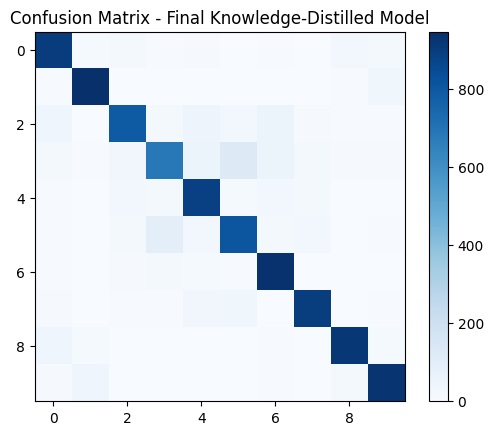

In [26]:
# Evaluate the quantized final KD model
quant_final_kd_acc = evaluate_tflite_model(quantized_final_kd_path, x_test, y_test)
print(f"Final KD model (INT8) test accuracy: {quant_final_kd_acc:.4f}")


final_kd_params = final_kd_model.count_params() 

show_confusion_matrix(final_kd_model, "Final Knowledge-Distilled Model")

## **Model Comparison: Parameters vs. Accuracy (INT8 Quantized)**

This final comparison clearly illustrates how the three different models—**Teacher**, **Small**, and **Final KD (Knowledge-Distilled)**—perform when fully quantized (INT8):

- The scatter plot visually represents the relationship between the number of parameters (model complexity) and the accuracy on the test set.  
  - **X-axis:** Number of parameters (model complexity).
  - **Y-axis:** Test accuracy (performance).

- Below the plot, the exact numerical accuracies and sizes (in kilobytes) of each quantized INT8 model are displayed for precise comparison.

**Insights from this comparison:**
- You can clearly observe the trade-offs between **model complexity**, **memory usage**, and **model accuracy**.
- This helps identify which model offers the best balance between performance and efficiency.

**Discussion Questions:**
- Which model provides the best trade-off between size and accuracy?
- How does knowledge distillation affect the accuracy and size compared to the original models?
- In practical deployment scenarios, which model would you choose, and why?

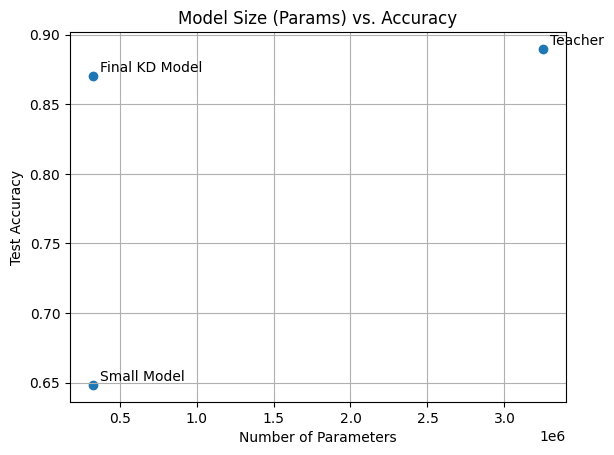


===== Comparison =====
Teacher model accuracy (INT8):	0.8884
Small model accuracy (INT8):	0.6507
KD model accuracy (INT8):	0.8706

Teacher model parameters:	3253834	(3177.5723 KB)
Small model parameters:		324394	(316.7910 KB)
KD model parameters:		324394	(316.7910 KB)


In [27]:
model_names   = ["Teacher", "Small Model", "Final KD Model"]
model_params  = [teacher_params,    small_params,    final_kd_params]
model_accs    = [teacher_acc,       small_model_acc,       quant_final_kd_acc]

plt.figure()
plt.scatter(model_params, model_accs)


for i, name in enumerate(model_names):
    plt.annotate(name, (model_params[i], model_accs[i]),
                 xytext=(5, 3), textcoords='offset points')

plt.title("Model Size (Params) vs. Accuracy")
plt.xlabel("Number of Parameters")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()



print("\n===== Comparison =====")

print(f"Teacher model accuracy (INT8):\t{teacher_quant_acc:.4f}")
print(f"Small model accuracy (INT8):\t{small_quantized_acc:.4f}")
print(f"KD model accuracy (INT8):\t{quant_final_kd_acc:.4f}")


print(f"\nTeacher model parameters:\t{teacher_params}\t({calc_memory_usage(teacher_params, BYTES_PER_INT8)[1]:.4f} KB)")
print(f"Small model parameters:\t\t{small_params}\t({calc_memory_usage(small_params, BYTES_PER_INT8)[1]:.4f} KB)")
print(f"KD model parameters:\t\t{final_kd_params}\t({calc_memory_usage(final_kd_params, BYTES_PER_INT8)[1]:.4f} KB)")



## **Inference Speed Comparison: Teacher vs Knowledge-Distilled Model**

This cell measures and compares the **inference speed** of two trained models:

The inference time is measured on the entire CIFAR-10 test set, averaged over multiple runs (3 runs by default) to ensure accuracy in timing.

### **Metrics Calculated:**
- **Total Inference Time**: How long it takes to run predictions over the entire test set.
- **Average Inference Time per Image**: Helpful for practical deployment considerations.

### **Questions to Consider:**
- Which model offers better performance-to-speed trade-offs?

In [28]:
import time

def measure_inference_time(model, x_test, num_runs=1):
    """
    Measures how long it takes for 'model' to do inference on x_test.
    Optionally runs multiple times (num_runs) and averages to reduce variance.
    Returns total time and time per image.
    """
    total_time = 0.0
    for _ in range(num_runs):
        start = time.time()
        _ = model.predict(x_test, verbose=0)
        end = time.time()
        total_time += (end - start)
    
    avg_time = total_time / num_runs
    time_per_image = avg_time / x_test.shape[0]
    return avg_time, time_per_image

# Example usage:
teacher_total, teacher_per_img = measure_inference_time(teacher_model, x_test, num_runs=3)
kd_total, kd_per_img = measure_inference_time(final_kd_model, x_test, num_runs=3)

print("===== Inference Time Comparison =====")
print(f"Teacher model - total inference time (test set): {teacher_total:.4f} s (avg of 3 runs)")
print(f"Teacher model - time per inference:             {teacher_per_img:.6f} s")

print(f"\nFinal KD model - total inference time (test set): {kd_total:.4f} s (avg of 3 runs)")
print(f"Final KD model - time per inference:             {kd_per_img:.6f} s")

if teacher_per_img < kd_per_img:
    ratio = kd_per_img / teacher_per_img
    print(f"\nTeacher model is approximately {ratio:.2f}x faster than Final KD model.")
else:
    ratio = teacher_per_img / kd_per_img
    print(f"\nFinal KD model is approximately {ratio:.2f}x faster than Teacher model.")


===== Inference Time Comparison =====
Teacher model - total inference time (test set): 22.1821 s (avg of 3 runs)
Teacher model - time per inference:             0.002218 s

Final KD model - total inference time (test set): 5.3581 s (avg of 3 runs)
Final KD model - time per inference:             0.000536 s

Final KD model is approximately 4.14x faster than Teacher model.


## **Convert Quantized TFLite Model (.tflite) to C Source Array (.h)**

To deploy your trained model on embedded systems, it's often helpful to convert your TensorFlow Lite model into a C/C++ byte array. This format allows direct embedding of the model into microcontroller projects or other embedded applications.

In this cell, we convert your previously quantized TFLite model (`quantized_final_kd_model.tflite`) into a C array format (`.h` file).

#### After saving the byte array, it may take a bit time to open the saved .h file to see its content. To explore it, using **nano** text editor or using **cat** directly in your terminal may help.

In [29]:
# Path to your quantized TFLite model
tflite_model_path = "quantized_final_kd_model.tflite"

# Output C array file
c_array_filename = "quantized_final_kd_model.h"

# Convert .tflite to C byte array
with open(tflite_model_path, "rb") as f:
    tflite_model_content = f.read()

hex_array = ', '.join(f'0x{byte:02x}' for byte in tflite_model_content)
c_source_code = f"""
#ifndef QUANTIZED_FINAL_KD_MODEL_H
#define QUANTIZED_FINAL_KD_MODEL_H

const unsigned char quantized_final_kd_model[] = {{
    {hex_array}
}};
const unsigned int quantized_final_kd_model_len = {len(tflite_model_content)};
#endif // QUANTIZED_FINAL_KD_MODEL_TFLITE
"""

# Save as .h file
c_model_path = "quantized_final_model.h"
with open(c_model_path, "w") as f:
    f.write(c_source_code)

print(f"C/C++ header file saved as: {c_model_path}")

print(f"Model size: {len(tflite_model_content)} bytes ({len(tflite_model_content)/1024:.2f} KB)")


C/C++ header file saved as: quantized_final_model.h
Model size: 347224 bytes (339.09 KB)
